In [9]:
import math
from graphviz import Digraph

In [14]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [92]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), \
            "Only supporting integers or floats for now"
        
        out = Value(self.data**other, (self, ), _op=f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out =  Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# SOP
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

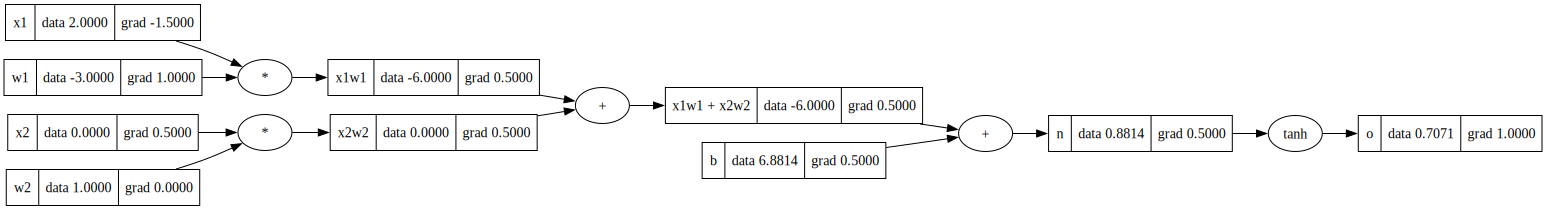

In [41]:
draw_dot(o)

In [40]:
o.backward()

<h5>Expanded tanh

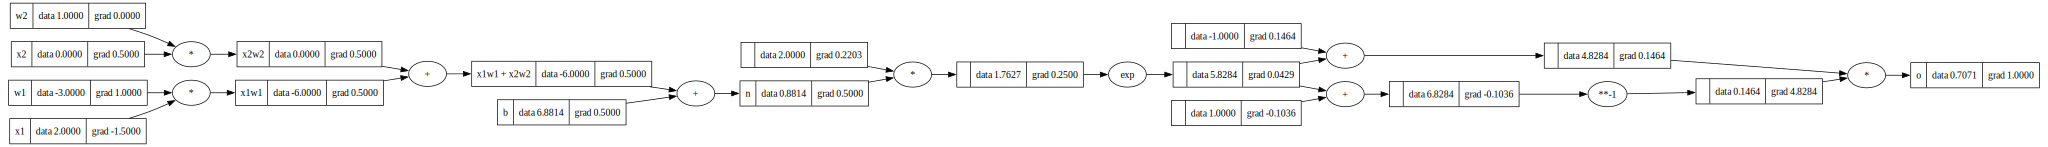

In [15]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# SOP
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [17]:
import torch

<h5> in comparison to pytorch

In [19]:
x1 = torch.Tensor([2.0]).double();      x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();      x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();      w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();      w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369


In [21]:
import random

In [89]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range((nout))]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def __repr__(self):
        return str(len(self.neurons))
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __repr__(self):
        res = ''
        for layer in self.layers:
           res += f"{layer}\n--------\n"
        return res
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [93]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [94]:
n.parameters()

[Value(data=0.10068198239990034, grad=0.0),
 Value(data=-0.5874801710284676, grad=0.0),
 Value(data=-0.7892298026822313, grad=0.0),
 Value(data=-0.03315355463775149, grad=0.0),
 Value(data=0.10934194552471421, grad=0.0),
 Value(data=-0.8648597359606012, grad=0.0),
 Value(data=-0.9859335124508597, grad=0.0),
 Value(data=0.2667490240574246, grad=0.0),
 Value(data=0.49801884468848634, grad=0.0),
 Value(data=0.5596781184833572, grad=0.0),
 Value(data=0.9941473403733938, grad=0.0),
 Value(data=0.3578430799667003, grad=0.0),
 Value(data=0.9451098546545948, grad=0.0),
 Value(data=-0.8922100329755065, grad=0.0),
 Value(data=-0.35274471152315856, grad=0.0),
 Value(data=-0.26621858241102725, grad=0.0),
 Value(data=-0.06380742194239186, grad=0.0),
 Value(data=0.46313765800569473, grad=0.0),
 Value(data=-0.4651470102889401, grad=0.0),
 Value(data=-0.44106870576119994, grad=0.0),
 Value(data=0.21840779955417644, grad=0.0),
 Value(data=0.7127388169735949, grad=0.0),
 Value(data=-0.9499941121843476, 

<h5>simple dataset

In [95]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.6],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

Y = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in X]
ypred

[Value(data=-0.15775924303518152, grad=0.0),
 Value(data=-0.1943768827015086, grad=0.0),
 Value(data=-0.11024879601075831, grad=0.0),
 Value(data=-0.03722218856859832, grad=0.0)]

In [96]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(Y, ypred))
loss

Value(data=3.8569221454184737, grad=0.0)

In [97]:
loss.backward()
loss

Value(data=3.8569221454184737, grad=1.0)

In [98]:
n.layers[0].neurons[0].w[0]

Value(data=0.10068198239990034, grad=-0.8636228234078556)

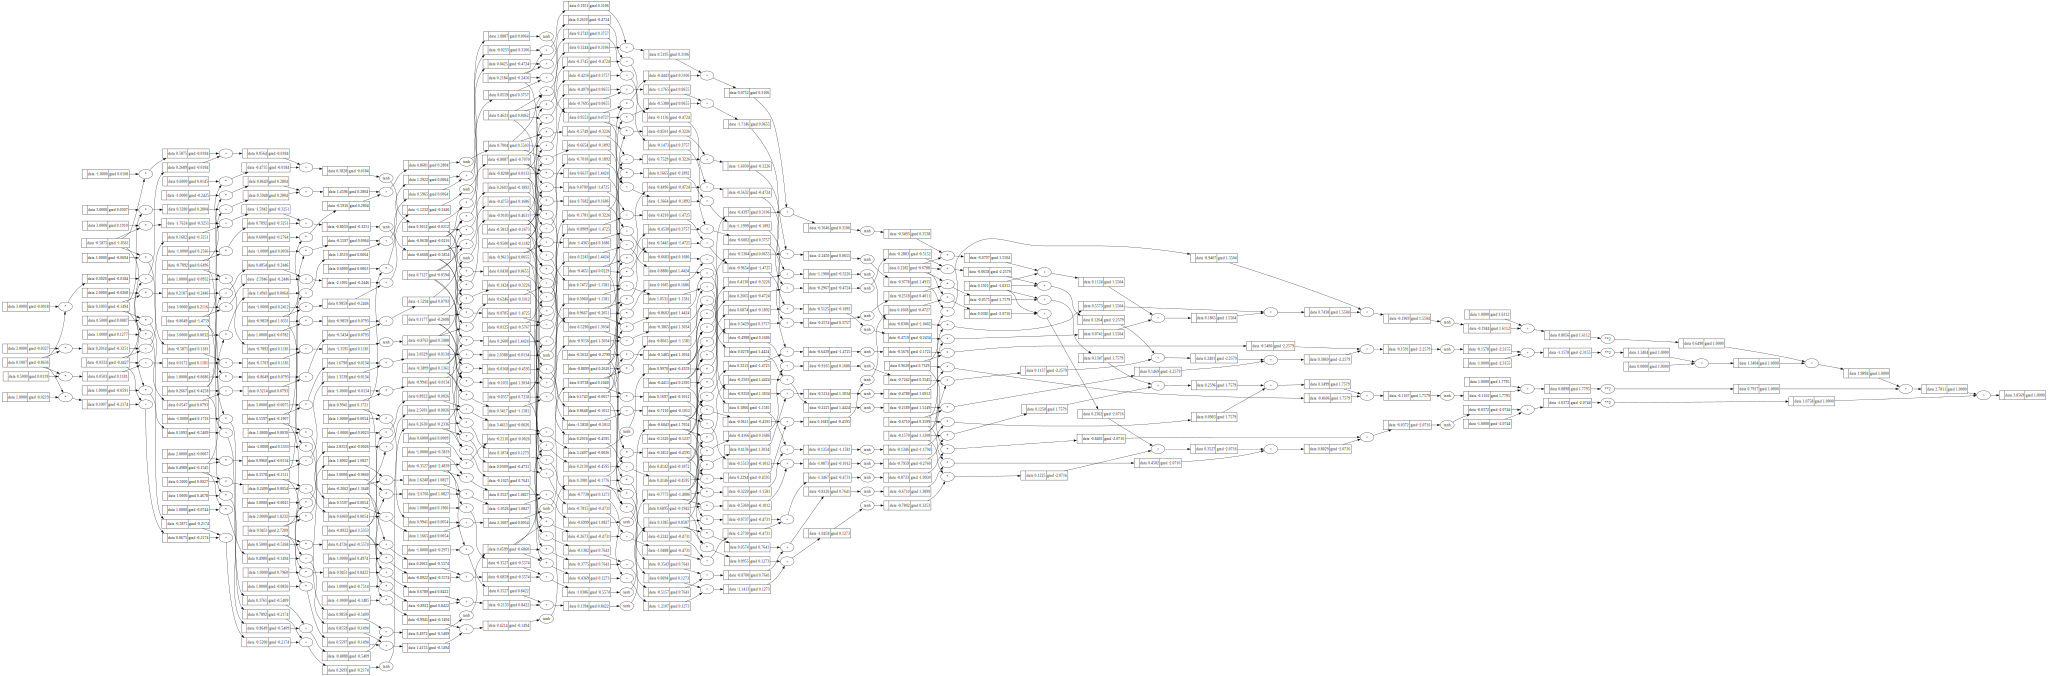

In [99]:
draw_dot(loss)